In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import keras
from keras.layers import LSTM, Dense, Activation, RNN
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

data = sio.loadmat("Xtrain.mat")["Xtrain"]
print(data.shape)
# create a scaler and fit it on data
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)

data_normed = scaler.transform(data)

Using TensorFlow backend.


(1000, 1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


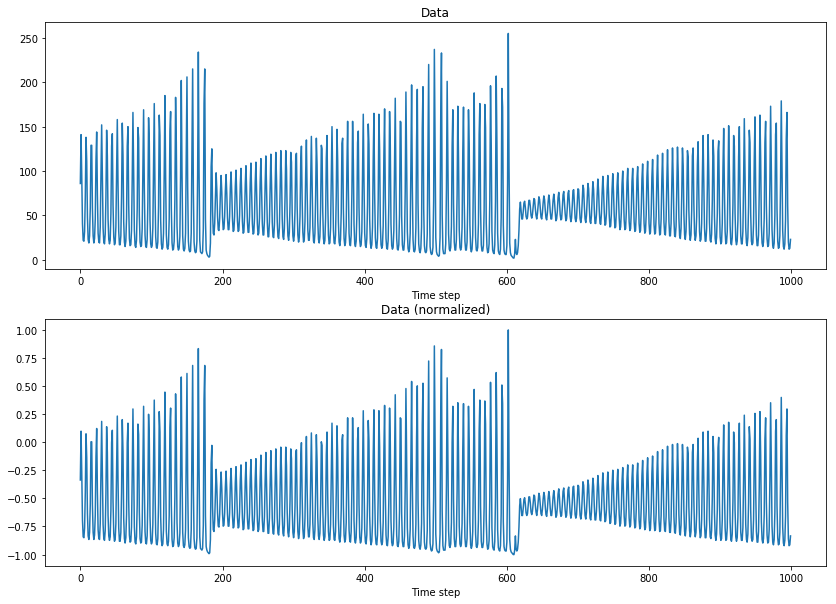

In [2]:
plt.figure(figsize=(14,10))
plt.subplot(211)
plt.plot(data)
plt.title("Data")
plt.xlabel("Time step")

plt.subplot(212)
plt.plot(data_normed)
plt.title("Data (normalized)")
plt.xlabel("Time step")
plt.show()

In [3]:
inputsize = 200

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def get_model():
    model = keras.Sequential()
    model.add(LSTM(32, return_sequences=False, input_shape=(trainX.shape[1], 1)))
#     model.add(Dense(16, activation='tanh'))
#     model.add(Dense(8, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss=root_mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
    return model

# Create train and test data (model is trained on sequence and should predict the next timestep)
targetIndex = np.array(range(inputsize, len(data)))

# Compare normalized and not normalized data (data/data_normed)
inputdata = np.array([data_normed[ind-inputsize:ind] for ind in targetIndex])
target = data_normed[targetIndex]

print(f'inputdata Shape {inputdata.shape}')
print(f'target Shape {target.shape}')

# Split into train and test
splitInd = int(len(inputdata)*0.9)
trainX = inputdata[:splitInd]
trainY = target[:splitInd]
testX = inputdata[splitInd:]
testY = target[splitInd:]
print("trainX.shape", trainX.shape)
print("trainY.shape", trainY.shape)
print("testX.shape", testX.shape)
print("testY.shape", testY.shape)

loadModel = True

if loadModel:
    model = keras.models.load_model("model.h5", custom_objects={'root_mean_squared_error': root_mean_squared_error})
else:
    # Create model
    model = get_model()
    # Train it
    history = model.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), verbose=2, shuffle=False)
    # Save it
    model.save("model.h5")

inputdata Shape (800, 200, 1)
target Shape (800, 1)
trainX.shape (720, 200, 1)
trainY.shape (720, 1)
testX.shape (80, 200, 1)
testY.shape (80, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


pred.shape  (80, 1)


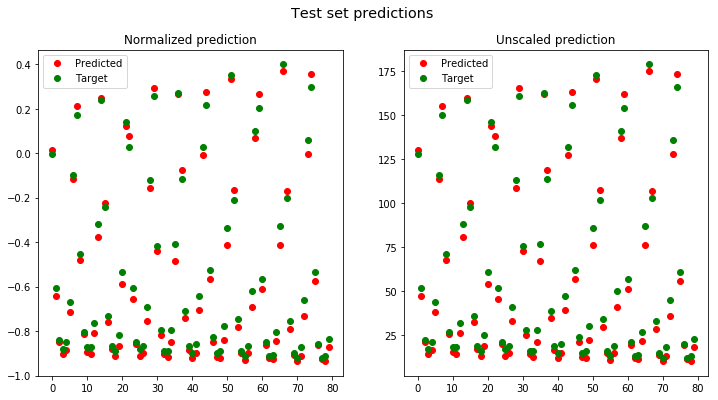

In [4]:
pred = model.predict(testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)
print("pred.shape ", pred.shape)

plt.figure(figsize=(12,6))
plt.suptitle("Test set predictions", fontsize="x-large")
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

if not loadModel:
    plt.title('Loss development')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

## Predict a timeseries of 200 timesteps recursively

(1000, 1)


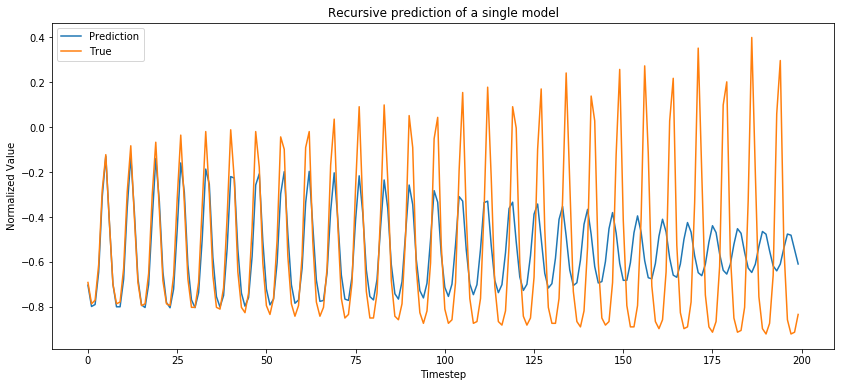

In [5]:
def forecast(model, inp, timesteps=200):
    output = inp
    for i in range(timesteps):
        # make forecast
        pred = model.predict(inp.reshape(1, len(inp),1))
#         print(pred)
        # add it and use it as new input
        output = np.append(output, pred)
        inp = output[-inputsize:]
    return output[-timesteps:]

print(data_normed.shape)
i = 800
forecast_pred = forecast(model, data_normed[i-inputsize:i], 200)
true_forecast = data_normed[i:i+200]
plt.figure(figsize=(14,6))
plt.title("Recursive prediction of a single model")
plt.plot(forecast_pred, label='Prediction')
plt.plot(true_forecast, label='True')
plt.ylabel("Normalized Value")
plt.xlabel("Timestep")
plt.legend()
plt.show()

## Try to implement K-Fold crossvalidation and save the n-best models to use as ensemble

In [6]:
def save_models(models):
    for i, m in enumerate(models):
        m.save(f"models/model{i}.h5")
    print("Saved models")

def load_models(folder='models'):
    files = os.listdir(folder)
    models = []
    for f in files:
        print("Load model: ", f)
        loaded_model = keras.models.load_model(f"{folder}/{f}", custom_objects={'root_mean_squared_error': root_mean_squared_error})
        models.append(loaded_model)
    return models

loadModels = True

if loadModels:
    models = load_models(folder='models_32_1_100epochs')
else:
    models = []
    n_folds = 10
    kf = KFold(n_splits=n_folds)
    iteration = 0
    for train_index, test_index in kf.split(inputdata, target):
        trainX, trainY = inputdata[train_index], target[train_index]
        testX, testY = inputdata[test_index], target[test_index]

        # Create model
        model = get_model()
        # Train it
        history = model.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), verbose=2)
        # Save it
        model.save(f"models/model{iteration}.h5")

        models.append(model)
        score = model.evaluate(testX, testY)[0]
        print(f'Iteration: {iteration} with score: {score}')
        iteration += 1

Load model:  model0.h5
Load model:  model1.h5
Load model:  model2.h5
Load model:  model3.h5
Load model:  model4.h5
Load model:  model5.h5
Load model:  model6.h5
Load model:  model7.h5
Load model:  model8.h5
Load model:  model9.h5


> 1: single=0.365, ensemble=0.366
> 2: single=0.025, ensemble=0.187
> 3: single=0.011, ensemble=0.125
> 4: single=0.012, ensemble=0.093
> 5: single=0.059, ensemble=0.069
> 6: single=0.016, ensemble=0.058
> 7: single=0.023, ensemble=0.048
> 8: single=0.031, ensemble=0.045
> 9: single=0.020, ensemble=0.040
> 10: single=0.022, ensemble=0.036
MSE 0.058 (0.103)


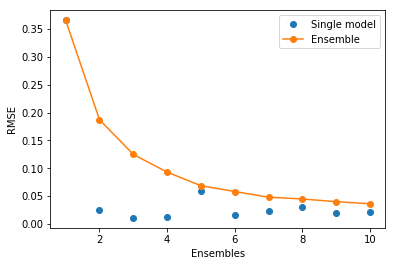

In [7]:
def ensemble_predictions(models, testX):
    # make predictions
    yhats = [model.predict(testX) for model in models]
    # mean across ensemble members
    result = np.mean(yhats, axis=0)
    return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(models, n_models, testX, testy):
    # select a subset of members
    subset = models[:n_models]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate RMSE
    rmse = np.sqrt(np.mean((testy-yhat)**2))
    return rmse

def forecast_ensemble(models, inp, timesteps=200):
    output = inp
    for i in range(timesteps):
        # make forecast
        pred = ensemble_predictions(models, inp.reshape(1, len(inp),1))
        # add it and use it as new input
        output = np.append(output, pred)
        inp = output[-inputsize:]
    return output[-timesteps:]
    

validationX, validationY = testX, testY
single_RMSEs, ensemble_RMSEs = [], []
for i in range(1, len(models)+1):
    ensemble_RMSE = evaluate_n_members(models, i, validationX, validationY)
    single_RMSE, _ = models[i-1].evaluate(validationX, validationY, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_RMSE, ensemble_RMSE))
    ensemble_RMSEs.append(ensemble_RMSE)
    single_RMSEs.append(single_RMSE)
# plot score vs number of ensemble members
print('MSE %.3f (%.3f)' % (np.mean(single_RMSEs), np.std(single_RMSEs)))
x_axis = [i for i in range(1, len(models)+1)]
plt.plot(x_axis, single_RMSEs, marker='o', linestyle='None', label='Single model')
plt.plot(x_axis, ensemble_RMSEs, marker='o', label="Ensemble")
plt.ylabel('RMSE')
plt.xlabel('Ensembles')
plt.legend()
plt.show()


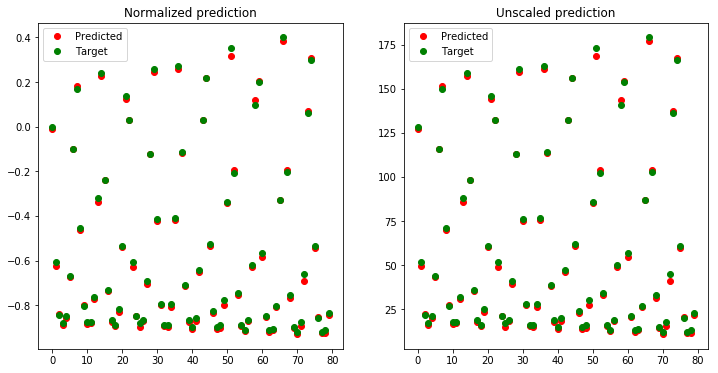

MSE:  0.0001331967963585215
(720, 200, 1)


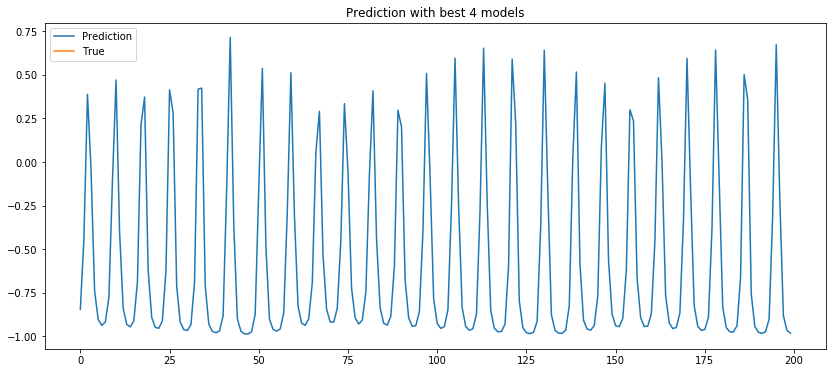

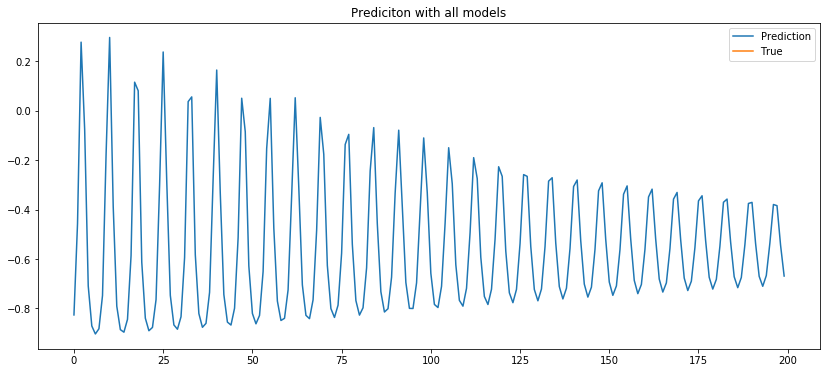

In [8]:
# get the best models and use these as ensemble
bestMask = np.argsort(single_RMSEs)
modelsToUse = [models[i] for i in bestMask][:4]

# compare with top-k models and all models
pred = ensemble_predictions(modelsToUse, testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

print("MSE: ", mean_squared_error(testY, pred))

print(trainX.shape)
i = 999
forecast_pred_top = forecast_ensemble(modelsToUse, data_normed[i-inputsize:i], 200)
# true_forecast = trainX[i+200][-200:]
true_forecast = data_normed[i:i+200]
plt.figure(figsize=(14,6))
plt.title("Prediction with best 4 models")
plt.plot(forecast_pred_top, label='Prediction')
plt.plot(true_forecast, label='True')
plt.legend()
plt.show()
forecast_pred = forecast_ensemble(models, data_normed[i-inputsize:i], 200)
# true_forecast = trainX[i+200][-200:]
true_forecast = data_normed[i:i+200]
plt.figure(figsize=(14,6))
plt.title("Prediciton with all models")
plt.plot(forecast_pred, label='Prediction')
plt.plot(true_forecast, label='True')
plt.legend()
plt.show()

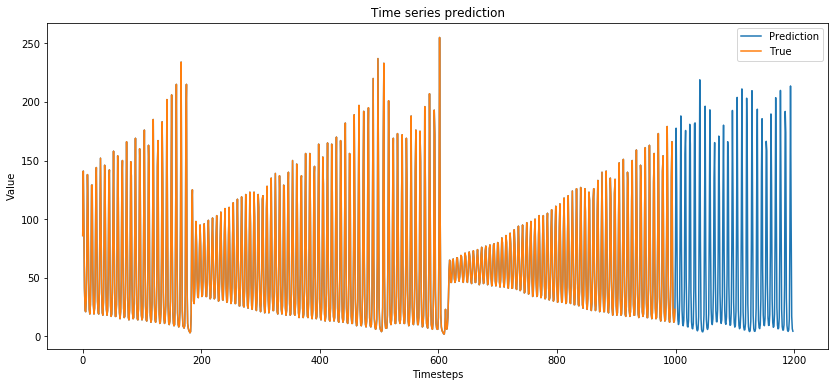

In [9]:
plt.figure(figsize=(14,6))
plt.title("Time series prediction")
predToPlot = np.append(data[:i], scaler.inverse_transform(forecast_pred_top.reshape(-1, 1)))
plt.plot(predToPlot, label='Prediction')
plt.plot(data[:i+200], label='True')
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.legend()
plt.show()